# Table of Contents
 <p><div class="lev1"><a href="#Implementing-BFS-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Implementing BFS</a></div><div class="lev1"><a href="#Intro-to-the-Maximum-Flow-Problem-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Intro to the Maximum Flow Problem</a></div><div class="lev2"><a href="#A-Naive-Greedy-Algorithm-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>A Naive Greedy Algorithm</a></div><div class="lev2"><a href="#Residual-Graphs-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Residual Graphs</a></div><div class="lev2"><a href="#Ford-Fulkerson-Algorithm-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Ford-Fulkerson Algorithm</a></div><div class="lev2"><a href="#NetworkXを用いて最大流問題を解く-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>NetworkXを用いて最大流問題を解く</a></div>

# Implementing BFS

まず準備として、始点と終点が指定されたときに始点から終点に至るパスのうちの一つを求めるアルゴリズムを実装したい。「Breadth First Search(BFS, 幅優先探索)やDFS(Depth First Search)を用いて実装できる」とレクチャーノートに書いてあるので、試しにBFSを用いて実装してみる。

BFSの実装にはQueueというデータ構造を用いる。(cf: DFSではstackを用いる。)Pythonでは、dequeというデータ構造（stackとqueueを合わせたようなデータ構造）が提供されているので、それを用いる。

[このページ](http://www.ocw.titech.ac.jp/index.php?module=General&action=DownLoad&file=201602093-9183-1-11.pdf&type=cal&JWC=201602093)も参考になりそう。

実装に当たって、NetworkXというpythonのグラフライブラリを利用している。詳しい使い方は[公式サイトのチュートリアル](http://networkx.readthedocs.io/en/networkx-1.11/tutorial/)等が参考になる。

>Given a graph $G$ and a starting vertex $s$, a breadth first search proceeds by exploring edges in the graph to find all the vertices in $G$ for which there is a path from $s$. The remarkable thing about a breadth first search is that it finds all the vertices that are a distance $k$ from ss before it finds any vertices that are a distance $k+1$. (http://interactivepython.org/runestone/static/pythonds/Graphs/ImplementingBreadthFirstSearch.html)

In [11]:
# dequeをimport
from collections import deque

In [12]:
# dequeのメソッドの確認

d = deque([1,2,3,4,5])
print (d)

# append: push/enqueueに対応
d.append(0)
print (d)

# pop: 右の要素を削除し、返す
print (d.pop())
print (d)

# popleft: 一番左の要素を削除し、返す
print (d.popleft())
print (d)

deque([1, 2, 3, 4, 5])
deque([1, 2, 3, 4, 5, 0])
0
deque([1, 2, 3, 4, 5])
1
deque([2, 3, 4, 5])


In [29]:
# NetworkXをインポート
import networkx as nx

In [54]:
G = nx.DiGraph()

In [55]:
G.add_edges_from([(1,2),(1,3),(1,4),(2,4),(2,5),(3,4),(4,5)])

In [6]:
import matplotlib.pyplot as plt

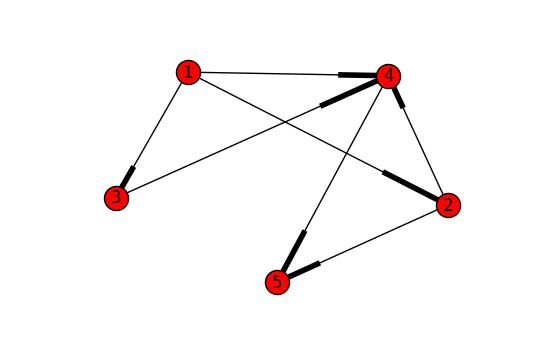

In [7]:
#試しに描画してみる
# Position nodes using Fruchterman-Reingold force-directed algorithm.
pos = nx.spring_layout(G, k=5.)

# Draw labels for nodes and edges.
nx.draw_networkx_labels(G, pos)

# Finish drawing.
nx.draw(G, pos)

# Display with Matplotlib.
plt.axis('off')
plt.show()

In [56]:
G.successors(1)

[2, 3, 4]

In [66]:
def bfsPath(G, s, e):
    '''
    BFSを用いて、sからeへのpathを一つ求める。
    Inputs:
        G: a graph
        s: a start point
        e: an end point
    Output:
        path: a list of edges which represents a path from s to e.
        the number of nodes the path contains is smallest.
    '''

    past = [] # 過去に訪れた点を記録
    path = []

    # 全ての点のsからの距離の初期値を無限大に
    for p in G.nodes():
        G.node[p]['dist'] = float('inf')
    
    # node s の距離を0に
    G.node[s]['dist'] = 0
    
    # sに隣接する点をqueueに
    queue = deque(G.successors(s))
    
    # sに隣接する点の距離を1に
    for p in G.successors(s):
        G.node[p]['dist'] = 1
    
    # この部分がBFS
    while len(queue)>0:
        v = queue.popleft()
        if v == e: break
        else:
            past.append(v)
            for p in G.successors(v):
                if (not p in past):
                    queue.append(p)
                    if G.node[p]['dist'] > G.node[v]['dist'] + 1:
                        G.node[p]['dist'] = G.node[v]['dist'] + 1
    
    # pathが存在しない場合はNoneを返す
    if len(G.successors(s)) == 0:
        v = s
    if v != e or v == s:
        print ('There is no path.')
        return None
    
    # 終点から遡ってpathを形成する
    pp = e
    while (1):
        if pp == s:
            break
        pred = G.predecessors(pp)
        for p in pred:
            if G.node[p]['dist'] == G.node[pp]['dist']-1:
                path.insert(0, (p,pp))
                pp = p
                break
    
    return path

In [67]:
# G上の1から5に至るpathの一つを求める
bfsPath(G,1,5)

[(1, 2), (2, 5)]

In [68]:
# from 3 to 5
bfsPath(G,3,5)

[(3, 4), (4, 5)]

In [69]:
# from 5 to 1
bfsPath(G,5,1)

There is no path.


# Intro to the Maximum Flow Problem

前節で作ったbfsPathを元に、naive greedy algorithmを実装することがこの節の目標。

とりあえず、例のグラフを作ってみる。

In [49]:
G = nx.DiGraph()
G.add_edges_from([('s','v',{'cap': 3}),('s','w',{'cap': 2}),('v','w',{'cap': 5}),('v','t',{'cap': 2}),('w','t',{'cap': 3})])

#flowを初期化
for e in G.edges():
    G[e[0]][e[1]]['flow'] = 0

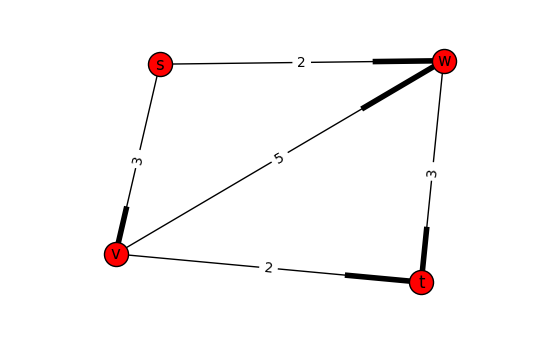

In [51]:
# 描画(edgeについている数字はcapacity)

# Position nodes using Fruchterman-Reingold force-directed algorithm.
    # 点の位置はランダムに決まるので、出来上がったグラフの形が微妙だったら、何回かやり直せばよい。
    # 座標を指定することもできるので、点の数が少ない場合は手動で形を決めた方が良いかも（後述）
pos = nx.spring_layout(G, k=5.)

# Draw only weight attribute as edge label.
edge_labels = {(i, j): w['cap'] for i, j, w in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

# Draw labels for nodes and edges.
nx.draw_networkx_labels(G, pos)

# Finish drawing.
nx.draw(G, pos)

# Display with Matplotlib.
plt.axis('off')
plt.show()

## A Naive Greedy Algorithm

In [4]:
# もろもろをインポート
import networkx as nx
import matplotlib.pyplot as plt
from collections import deque

In [5]:
# 例のグラフGを生成
G = nx.DiGraph()
G.add_edges_from([('s','v',{'cap': 3}),('s','w',{'cap': 2}),('v','w',{'cap': 5}),('v','t',{'cap': 2}),('w','t',{'cap': 3})])
for e in G.edges():
    G[e[0]][e[1]]['flow'] = 0

まず、前節で作ったbfsPath（flowやcapacityについては考慮してなかった）を、naive greedy algorithmの中で使えるもの(bfsFlowPath)に改変する。

In [4]:
def bfsFlowPath(G, s, e):
    '''
    Inputs:
        G: a graph
        s: a start point
        e: an end point
        each edge has two attributes:
            cap: capacity
            flow: its current flow which should be no more than its capacity
    Output:
        path: a list of edges which represents a path from s to e.
        At each node of the path, its current flow is strictly less than its capacity.
        In case there is no path from s to t, return None.
    '''

    past = [] # 過去に訪れた点を記録
    path = []

    # 全ての点のsからの距離の初期値を無限大に
    for p in G.nodes():
        G.node[p]['dist'] = float('inf')
    
    # node s の距離を0に
    G.node[s]['dist'] = 0
    
    # sに隣接する点をqueueに
    # queueには、今後訪れるべき点が格納される
    queue = deque()
    for p in G.successors(s):
        # current flow < capacity となるedgeだけをpathの候補に
        # flow < capacity となるedge以外は存在しないものとして扱うのと同じ
        if G[s][p]['flow'] < G[s][p]['cap']:
            queue.append(p)
            
    # あとで条件分岐に用いる
    numberOfSuccessorsOfSource = len(queue)
    
    # sに隣接する点の距離を1に
    for p in queue:
        G.node[p]['dist'] = 1

    # BFSを用いてflow < capを満たすsからeへのpathがあるのか調べる
    # pastに過去に訪れた点を格納
    while len(queue)>0:
        v = queue.popleft()
        if v == e: break
        else:
            past.append(v)
            for p in G.successors(v):
                # ここのif文の条件を変えた
                # (過去に訪れていない and flow < capacity)を満たすedge
                if ( (not p in past) and ( G[v][p]['flow'] < G[v][p]['cap']) ):
                    if ( not p in queue):
                        queue.append(p)
                    if G.node[p]['dist'] > G.node[v]['dist'] + 1:
                        G.node[p]['dist'] = G.node[v]['dist'] + 1

    # sからeへのpathが存在しない場合はNoneを返す
    if numberOfSuccessorsOfSource == 0:
        v = s
    if v != e or v == s:
        # print ('There is no path.')
        return None
    
    # 以下、sからeへのpathが存在する場合
    # 終点から遡ってpathを形成する
    pp = e
    while (1):
        if pp == s: break
            
        pred = G.predecessors(pp)
        
        count = 0

        for p in pred:
            # ここに、flow < cap の条件を追加
            # distの作り方から、flow < capは自然に満たされる
            if ( G.node[p]['dist'] == G.node[pp]['dist']-1):
                path.insert(0, (p,pp))
                pp = p
                break
            else:
                count += 1
        
        # 条件を満たすedgeがない
        if count == len(pred):
            break
    
    # pathがない場合
    # 無駄な条件か？（ここまで来ているのなら、pathはあるはず。念のため残しておく。）
    if path[0][0] != s:
        return None
    
    return path

In [117]:
# bfsFlowPathが機能することを確認
print ( bfsFlowPath(G,'s','t') )

[('s', 'w'), ('w', 't')]


In [118]:
# 確認その2
print ( bfsFlowPath(G,'t','w') )

None


In [119]:
# 確認その3
G['s']['w']['flow'] = 10
print ( bfsFlowPath(G,'s','w') )

[('s', 'v'), ('v', 'w')]


In [120]:
# 確認その4
G['s']['w']['flow'] = 10
print ( bfsFlowPath(G,'s','t') )

[('s', 'v'), ('v', 't')]


In [121]:
# 確認その5
G['s']['w']['flow'] = 2
G['s']['v']['flow'] = 3
print ( bfsFlowPath0(G, 's', 'w'))

None


bfsFlowPathはキチンと動いていそう。次に、Naive Greedy Algorithmを実装してみる。

In [37]:
def naiveGreedy(G, s, t):
    '''
    Inputs:
        G: a graph
        s: a source vertex
        t: a sink vertex
    Outputs:
        the graph G whose flow was modified by this naive greedy algorithm
        In case there is no path from s to t, return None.
    '''
    # initialize flows
    for e in G.edges():
        G[e[0]][e[1]]['flow'] = 0
    
    # そもそもsからtへのパスがあるのか確認
    path = bfsFlowPath(G, s, t)
    if path == None:
        print ("There is no path from " + str(s) + " to "+ str(t) )
        return None
    
    # sからtへのパスがある場合(lecture noteのA Naive Greedy Algorithmの部分に相当)
    while(1):
        path = bfsFlowPath(G, s, t)
        if path == None:
            break
        else:
            # path上のedgeについて、cap - flowの最小値を調べる
            min = float('inf')
            for edge in path:
                if ( min > G[edge[0]][edge[1]]['cap'] - G[edge[0]][edge[1]]['flow'] ):
                    min = G[edge[0]][edge[1]]['cap'] - G[edge[0]][edge[1]]['flow']
            
            # path上のedgeのflowを更新
            for edge in path:
                G[edge[0]][edge[1]]['flow'] += min
    
    return G

In [124]:
# 実験1
naiveGreedy(G,'t','s')

There is no path from t to s


In [125]:
# 実験2
G_opt = naiveGreedy(G, 's', 't') 

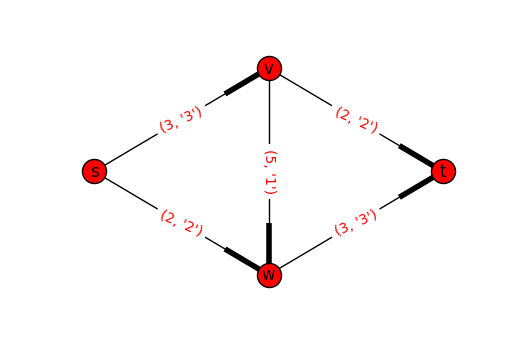

In [139]:
# 描画(edgeに付いている数字は(capacity, 'flow')の意味)

# Position nodes using Fruchterman-Reingold force-directed algorithm.
# pos = nx.spring_layout(G_opt, k=5.)

# 各ノードの座標を指定することも可能
pos={'s':(0,2),'v':(3,4),'w':(3,0),'t':(6,2)}

# flowとcapacityを同時に表示させようとしてみた
# なにが起きてるのかよくわからないけど、(capacity, 'flow')というかんじでうまいこと表示されてる
edge_labels = {(i, j): (w['cap'], str((w['flow'])) ) for i, j, w in G_opt.edges(data=True)}
nx.draw_networkx_edge_labels(G_opt, pos, edge_labels=edge_labels, font_color='r')

# Draw labels for nodes and edges.
nx.draw_networkx_labels(G_opt, pos)

# Finish drawing.
nx.draw(G_opt, pos)

# Display with Matplotlib.
plt.axis('off')
plt.show()

キチンと動いている。（この場合はたまたまnaive greedy algorithmでも最大流が実現されている。）

描画の際、
[公式ドキュメント](http://networkx.readthedocs.io/en/networkx-1.11/reference/generated/networkx.drawing.nx_pylab.draw_networkx_edge_labels.html#networkx.drawing.nx_pylab.draw_networkx_edge_labels)や[見つけたスライド](http://www.logopt.com/python_learning/wp-content/uploads/2015/10/networkx.pptx)を参考にした。

ノード数が小さいグラフであれば描画の際に各ノードの座標が指定した方が綺麗に描けそう。

## Residual Graphs

Ford-Fulkerson algorithmを実装する準備として、あるグラフについて、対応するResidual graphを生成する関数(*makeResidualGraph*)を作る必要がある。

In [3]:
def makeResidualGraph(G):
    '''
    Input: a graph G
    Output: its residual graph Gf
    '''
    Gf = G.copy()
    edgeList = G.edges()
    
    # 逆向きのedgeがないものは追加
    for edge in edgeList:
        if not (edge[1], edge[0]) in edgeList:
            Gf.add_edge(edge[1],edge[0])
            Gf[edge[1]][edge[0]]['cap'] = Gf[edge[0]][edge[1]]['flow']
            Gf[edge[1]][edge[0]]['flow'] = 0
    
    for edge in edgeList:
        Gf[edge[0]][edge[1]]['cap'] = Gf[edge[0]][edge[1]]['cap'] - Gf[edge[0]][edge[1]]['flow']
        Gf[edge[1]][edge[0]]['cap'] = Gf[edge[0]][edge[1]]['flow']
        Gf[edge[0]][edge[1]]['flow'] = 0
        Gf[edge[1]][edge[0]]['flow'] = 0
    
    return Gf

In [40]:
Gf = makeResidualGraph(G)

In [41]:
Gf.edges()

[('w', 't'),
 ('w', 's'),
 ('w', 'v'),
 ('t', 'w'),
 ('t', 'v'),
 ('s', 'w'),
 ('s', 'v'),
 ('v', 'w'),
 ('v', 't'),
 ('v', 's')]

In [43]:
print(Gf['s']['w']['flow'])
print(Gf['s']['w']['cap'])
print(Gf['w']['s']['flow'])
print(Gf['w']['s']['cap'])

0
2
0
0


きちんと動いていそうだ。

## Ford-Fulkerson Algorithm

Ford-Fulkerson Algorithmを実装してみる。

In [5]:
def fordFulkerson(G, s, t):
    '''
    Inputs:
        G: a graph
        s: a source vertex
        t: a sink vertex
    Outputs:
        the graph G whose flow was modified by Ford-Fulkerson algorithm
        In case there is no path from s to t, return None.
    '''
    # initialize flows
    for e in G.edges():
        G[e[0]][e[1]]['flow'] = 0
        
    # Forward edgesを記録
    forwardEdges = G.edges()
    
    # Residual Graphの作成
    Gf = makeResidualGraph(G)
    
    # そもそもGにおいてsからtへのパスがあるのか確認
    path = bfsFlowPath(G, s, t)
    if path == None:
        print ("There is no path from " + str(s) + " to "+ str(t) )
        return None
    
    # Gにおいてsからtへのパスがある場合
    while(1):
        path = bfsFlowPath(Gf, s, t)
        if path == None:
            break
        else:
            # path上のedgeについて、cap - flowの最小値を調べる
            min = float('inf')
            for edge in path:
                if ( min > Gf[edge[0]][edge[1]]['cap'] - Gf[edge[0]][edge[1]]['flow'] ):
                    min = Gf[edge[0]][edge[1]]['cap'] - Gf[edge[0]][edge[1]]['flow']
            
            # path上のedgeのflowを更新
            for edge in path:
                if edge in forwardEdges:
                    Gf[edge[0]][edge[1]]['flow'] += min
                else:
                    Gf[edge[1]][edge[0]]['flow'] -= min
    
    # もともと無かったedgeを消去
    for edge in Gf.edges():
        if not edge in forwardEdges:
            Gf.remove_edge(edge[0],edge[1])
    
    return Gf

In [6]:
# Ford-Fulkersonを用いて最大流を求めてみる
T = fordFulkerson(G, 's', 't')

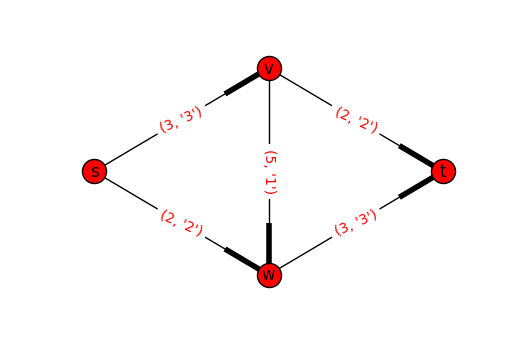

In [55]:
# 描画(edgeに付いている数字は(capacity, 'flow')の意味)

pos={'s':(0,2),'v':(3,4),'w':(3,0),'t':(6,2)}
edge_labels = {(i, j): (w['cap'], str((w['flow'])) ) for i, j, w in T.edges(data=True)}
nx.draw_networkx_edge_labels(T, pos, edge_labels=edge_labels, font_color='r')
nx.draw_networkx_labels(T, pos)
nx.draw(T, pos)
plt.axis('off')
plt.show()

## NetworkXを用いて最大流問題を解く

NetworkXには、各種ネットワーク問題を解くための機能が揃っている。ここでは最大流問題を解いてみる。

In [8]:
# 例のグラフGを生成
G = nx.DiGraph()
G.add_edges_from([('s','v',{'capacity': 3}),
                  ('s','w',{'capacity': 2}),
                  ('v','w',{'capacity': 5}),
                  ('v','t',{'capacity': 2}),
                  ('w','t',{'capacity': 3})])

In [11]:
flow_value, flows = nx.maximum_flow(G,'s','t')
print('maximum flow: {}'.format(flow_value))
#print(flows)

caps = nx.get_edge_attributes(G, 'capacity')
for u in nx.topological_sort(G):
    for v, flow in sorted(flows[u].items()):
        print('({}, {}): {}/{}'.format(u, v, flow, caps[(u, v)]))

maximum flow: 5
(s, v): 3/3
(s, w): 2/2
(v, t): 2/2
(v, w): 1/5
(w, t): 3/3
